# Tutorial: running xQML in a simple CMB+White noise setting

If you installed correctly the xQML package following the README instructions you should be able to run the following cell without errors.

In [1]:
import os.path as op
import numpy as np
import healpy as hp
from pylab import *
import timeit
import sys

import xqml
from xqml.xqml_utils import progress_bar, getstokes, pd_inv
from xqml.simulation import Karcmin2var
from xqml.simulation import extrapolpixwin, getNl
from xqml.libcov import compute_S, S_bins_MC, compute_ds_dcb

Let's now load the Cls file

In [2]:
# fiducial CMB theory spectrum computed via CAMB/Class
CURRENT_PATH = op.abspath('')
cls_file = CURRENT_PATH+'/ancillary_files/Cls_no_tensor_tutorial.npy'

We now define the resolution, binning width, beam fwhm used in the QML estimator.

QML of higher resolution maps (larger $N_{\rm side}$) is more expensive both in number of operations on the CPU (mainly inversion of the pixel-pixel covariance matrices) and storage in memory of pixel-pixel matrix.

The threshold parameter is needed because we start from a non-binary mask (the Planck Galactic plane one), we perform a downgrading in pixel space and then, since QML needs a binary mask, we need to threshold the mask. Therefore this value sets the threoshold below which the mask pixel will be set to zero, i.e. masked. 

We set also the number of simulations to be used later in our MC analysis.

In [3]:
# define QML parameters
nside = 8 # N_side resolution
dell = 1 # multipole bin dimension
fwhm = 1.33333 # beam in [deg] (this corresponds to 80 arcmin beam)

lmin = 2
lmax = 3 * nside - 1

thresh = 0.1 # threshold used in the 

nsimu = 1000 # number of simulations

xQML can produce all 6 spectra (TT, EE, BB, TE, TB, EB), but since we are only interested in EE and BB we set the "spec" variable accordingly. 

We set pixwin=True to convolve maps with a pixel window function defined later.

In [4]:
# provide list of specs to be computed, and/or options
spec = ['EE','BB']
pixwin = True  
muKarcmin = 10. # white noise level in muK-arcmin

Let's now load the input Cls theory spectrum from file. This is just a numpy array with [TT, EE, BB, TE] computed from CAMB with r=0, to which I append an array [TB,EB] of zeros. 

In [5]:
#input model
clth = np.load(cls_file)
clth = array( list(clth) + list(clth[0:2]*0.)) # append TB, EB spectra (both null)
lth = arange(2, lmax+1)

Now we read the Planck Galactic plane mask: we choose the field of the .fits file to read (they are ordered from 0 to 7 in increasing sky fraction from 20% to 99%).

Then we downgrade the mask in pixel space (in two steps because healpy can't handle it properly in just one step).

Then we threshold the mask.

In [6]:
# downgrade and threshold Planck galactic plane mask
planck_field = 2
pl_mask = hp.read_map(CURRENT_PATH+'/ancillary_files/HFI_Mask_GalPlane-apo0_2048_R2.00.fits', field=planck_field)
pl_mask = hp.ud_grade(pl_mask, nside_out=256) # bug in healpy? can't downgrade in just one step from native resolution to nside=16
pl_mask = hp.ud_grade(pl_mask, nside_out=64)
pl_mask = hp.ud_grade(pl_mask, nside_out=nside)
pl_mask[np.where(pl_mask<thresh)] = 0
pl_mask[np.where(pl_mask>=thresh)] = 1
mask = pl_mask

/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IM

Let's see how the mask looks

/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/p/pcampeti/.conda/envs/xqml_tutorial/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state o

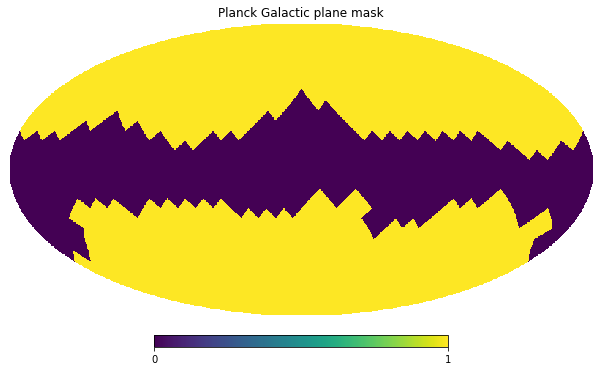

In [7]:
# show downgraded mask
hp.mollview(mask, title='Planck Galactic plane mask')

Let's print now the $f_{sky}$ and number of pixels we are using, together with some info about memory consumption.  

In [8]:
# print some relevant info 
fsky = np.mean(mask)
npix = np.int(sum(mask))
print("fsky=%.2g %% (npix=%d)" % (100*fsky,npix))
toGB = 1024. * 1024. * 1024.
emem = 8.*(npix*2*npix*2) * ( len(lth)*2 ) / toGB
print("mem=%.2g Gb" % emem)

fsky=65 % (npix=499)
mem=0.33 Gb


In [9]:
# define parameters used later
stokes, spec, istokes, ispecs = getstokes( spec=spec)
print(stokes, spec, istokes, ispecs)
nspec = len(spec)
nstoke = len(stokes)

['Q', 'U'] ['EE', 'BB'] [1, 2] [1, 2]


We create a simple gaussian beam with fwhm defined before

In [10]:
npixtot = len(mask)
mask = np.asarray(mask,bool)
ipok = np.arange(npixtot)[mask] # pixel indexes outside the mask
Slmax = lmax
fpixw = extrapolpixwin(nside, lmax, pixwin=pixwin)
bl = hp.gauss_beam(deg2rad(fwhm), lmax=lmax, pol=True) # beam starts from ell=0
bl = bl[:,2] # choose polarization beam
norm = bl[0: Slmax + 1]**2 * fpixw[0: Slmax + 1]**2

We create now the pixel-pixel (white) noise covariance matrix, which is diagonal in this simple case. In case your case of application provides enough realistic map simulations, you can also compute empirically a pixel-pixel noise covariance matrix which will probably have also off-diagonal components. 

In [11]:
# ############## Generate White Noise ###############
pixvar = Karcmin2var(muKarcmin, nside)
varmap = ones((nstoke * npix)) * pixvar
NoiseVar = np.diag(varmap)

We define the binning to use later for the estimated spectra

In [12]:
# define binning
bins = xqml.Bins.fromdeltal(lmin, lmax, dell)
lb = bins.lbin

And now we initialize the xqml estimator class. In this case we are using a serial version of xQML (different from the default version that can be downloaded from the xQML official repository), bypassing the parallel implementation in cython of the computation of the pixel-pixel signal covariance matrix. I tested this, while I didn't test the parallel implementation.

In [13]:
## ############## Initialise xqml estimator class ###############
esti = xqml.xQML(mask, bins, clth, NA=NoiseVar, NB=NoiseVar, lmax=lmax,
                fwhm=fwhm, spec=spec, pixwin=pixwin)

xQML
spec:  ['EE', 'BB']
nbin:  22
Memset: 0.33 Gb (2,22,2,499)
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [####################] 100% Done...
 [#########

We do now our Monte Carlo of simulations, estimating QML spectra on 1000 CMB + white noise maps. 

We generate the input maps as Gaussian realizations of the fiducial theory spectrum multiplied with the beam and pixel window function squared. 

All the spectra are stored into an array allcl

In [14]:
############## Construct MC ###############
allcl = []
t = []
nsimu_corr = nsimu
for n in range(nsimu_corr):
    progress_bar(n, nsimu_corr)
    seed = n # seed must be the same used in pseudo-cls simulations for consistency
    np.random.seed(seed)
    # generate Gaussian realizations from the fiducial theory spectrum
    cmb = np.array(hp.synfast(clth[:, :len(fpixw)]*(fpixw*bl)**2,
                                   nside,
                                   pixwin=False,
                                   lmax=lmax,
                                   fwhm=0.0,
                                   new=True,
                                   verbose=False))
    # mask map realization                               
    cmbm = cmb[istokes][:, mask]
    # create white noise map
    noise_map = np.random.randn(nstoke, npix) * sqrt(pixvar)
    # sum CMB signal and noise maps
    dmA = cmbm + noise_map
    s1 = timeit.default_timer()
    # call xqml estimator class
    allcl.append(esti.get_spectra(dmA, dmA)) # I use the cross-estimator but the two maps are the same so the output is an auto-spectrum 
    t.append( timeit.default_timer() - s1) # time the estimator 

 [####################] 100% Done...


In [15]:
print( "get_spectra: %f sec" % mean(t))

get_spectra: 0.011905 sec


Compute mean and standard deviation of the spectra.

In [16]:
hcl = mean(allcl, 0) # mean of the spectra at each ell
scl = std(allcl, 0) # standard deviation at each ell

We now save the pseudo-cls files in a .npy file. Note that the name contains a few info on the procedure used to estimate the spectrum.

In [17]:
# save simulations spectra
np.save('allcl_whitenoise_fsky'+str(fsky)+'_thresh_'+str(thresh)+'_field_'+str(planck_field)+'.npy', allcl)

This is a function computing the angular spectrum expected from the white noise

In [18]:
def Nell(depth_p, fwhm, lmax):  
    '''
    White noise spectrum expectation.
    beam fwhm in degrees.
    '''
    bl = hp.gauss_beam(np.radians(fwhm), lmax=lmax+1, pol=True)[:,2] 
    nl = (np.radians(depth_p/60.) / np.array(bl))**2 
    return nl[2:]

Finally we plot the results of the estimator and compare them to the theory and noise expectation and the sum of theoretical CMB spectrum and noise. First for BB, then for EE.

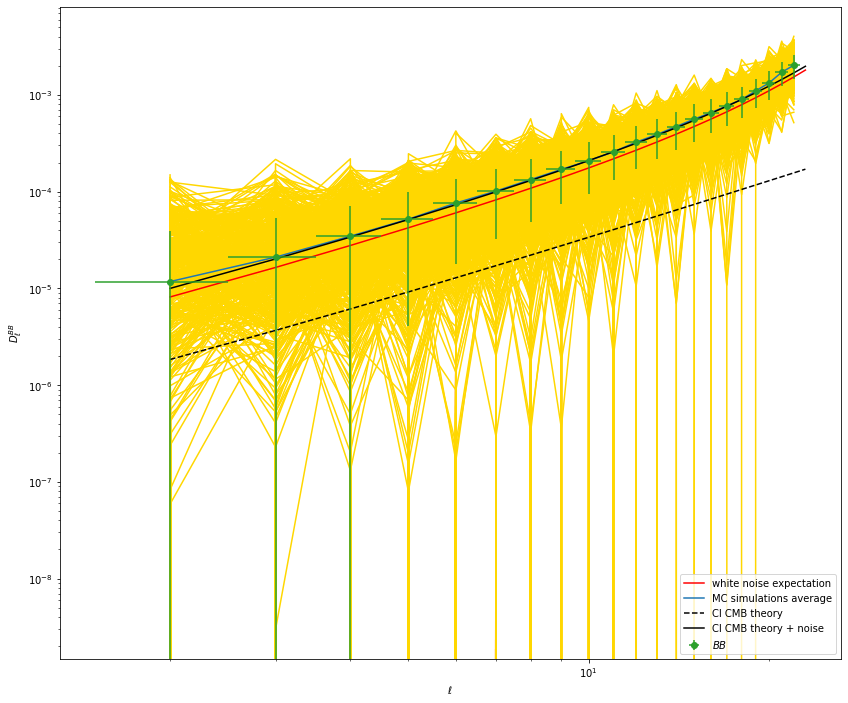

In [19]:
# ############## Plot estimator results ###############
ell = np.arange(2, lmax+1)
lb = lb[:-1]

# plot BB
fig = plt.figure(figsize=(14,12), facecolor='w', edgecolor='k')
ax = plt.gca()
toDl = lb*(lb+1)/2./np.pi

s=1 # take only BB spectra
for i in range(nsimu_corr):
    plot(lb, toDl*allcl[i][s], color='gold')
    
errorbar(lb, toDl*hcl[s], yerr=toDl*scl[s], xerr=(bins.dl/2)[:-1], fmt='o',
         color='C%i' % ispecs[s], label=r"$%s$" % spec[s], zorder=1000)
plot(ell, ell*(ell+1)/2./np.pi*Nell(muKarcmin, fwhm, lmax)[:-1]/fpixw[2:]**2, color='red', label='white noise expectation')
loglog()
plot(lb, toDl*hcl[s], label='MC simulations average')
plot(lth, lth*(lth+1)/2./np.pi*clth[2][2:max(lth)+1].T, '--k', label='Cl CMB theory')
plot(lth, lth*(lth+1)/2./np.pi*(clth[2][2:max(lth)+1].T+Nell(muKarcmin, fwhm, lmax)[:-1]/fpixw[2:]**2), '-', color='black', label='Cl CMB theory + noise')


ylabel(r"$D_\ell^{BB}$")
xlabel(r"$\ell$")
legend(loc=4, frameon=True)
savefig('xQML_BB_Planck_whitenoise_fsky'+str(fsky)+'.pdf', format='pdf', dpi=1000, bbox_inches='tight')
show()


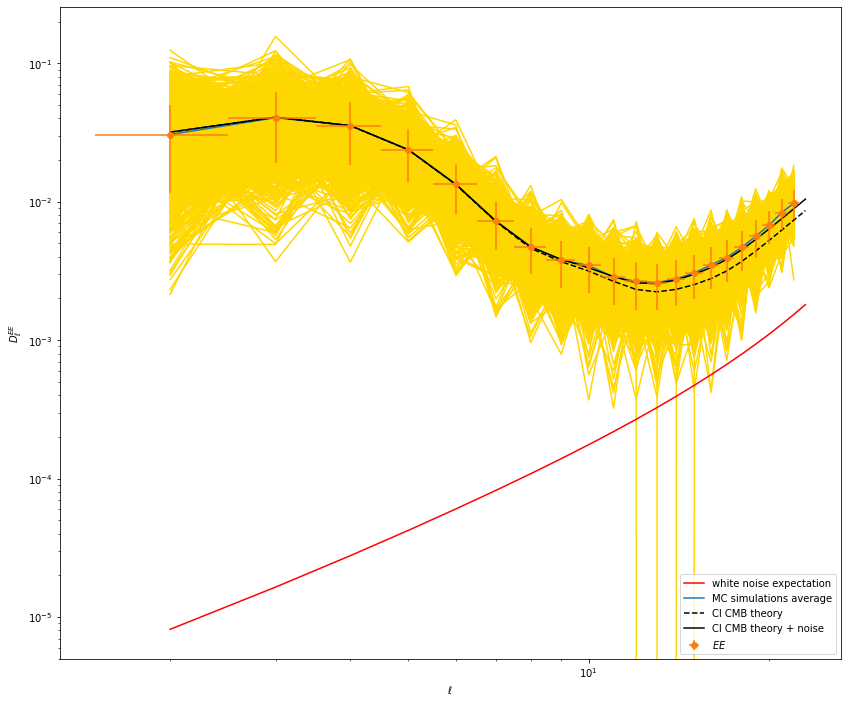

In [20]:
# plot EE
fig = plt.figure(figsize=(14,12), facecolor='w', edgecolor='k')
ax = plt.gca()

s=0 # take only EE spectra
for i in range(nsimu_corr):
    plot(lb, toDl*allcl[i][s], color='gold')
    
errorbar(lb, toDl*hcl[s], yerr=toDl*scl[s], xerr=(bins.dl/2)[:-1], fmt='o',
         color='C%i' % ispecs[s], label=r"$%s$" % spec[s], zorder=1000)
plot(ell, ell*(ell+1)/2./np.pi * Nell(muKarcmin, fwhm, lmax)[:-1]/fpixw[2:]**2, color='red', label='white noise expectation')
loglog()
plot(lb, toDl*hcl[s], label='MC simulations average')
plot(lth, lth*(lth+1)/2./np.pi*clth[1][2:max(lth)+1].T, '--k', label='Cl CMB theory')
plot(lth, lth*(lth+1)/2./np.pi*(clth[1][2:max(lth)+1].T+Nell(muKarcmin, fwhm, lmax)[:-1]/fpixw[2:]**2), '-', color='black', label='Cl CMB theory + noise')


ylabel(r"$D_\ell^{EE}$")
xlabel(r"$\ell$")
legend(loc=4, frameon=True)
savefig('xQML_EE_Planck_whitenoise_fsky'+str(fsky)+'.pdf', format='pdf', dpi=1000, bbox_inches='tight')
show()
